# **DO NOT run all cells, some functions take upwards of an hour to parse data**

<hr>

## Log file transformation playground

**Note**

A client connection is established when both Association and Authoriation are successful

How can a unique client be indentified? IP or Mac?
- https://community.nxp.com/t5/Wireless-Connectivity-Knowledge/802-11-Wi-Fi-Connection-Disconnection-process/ta-p/1121148 
- mac address is unique to device, IPs are unique but are periodically reused

Mac Address is better for identifying devices (IPs can change)
- https://www.cleverfiles.com/howto/what-is-mac-address.html

So in order for a connection to be established, both authorization and association need to succeed. When parsing the logs, need to check for Both auth and assoc in sequence.

Lots of duplicates in the data as well - mostly on assoc requests

Access Points also have mac addresses...

For the purposes of aggregating sums of users within a given area/building, it is not really necessary for a proper client connection to be established. Simply requesting association indicates a device is near a geographic area regardless or proper connection or not  

### Display Campus Map for Refeence

In [1]:
from IPython.display import IFrame
IFrame("Uncc_Campus_Temporal_Map24x36.pdf", width=900, height=800)

### Library Imports

In [9]:
import re
import os
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
os.getcwd()

'C:\\Users\\calvi\\Documents\\College\\UNCC\\Fall 2022\\ITSC 4155\\Project\\ETL'

### Manually tracing a mac address 

In [5]:
case = []
path = Path('C:\\Users\\calvi\\Documents\\College\\UNCC\\Fall 2022\\ITSC 4155\\Project\\dataset\\var\\log\\remote\\wireless-encoded\\wireless_09-29-2020.log')
with open(path, 'r') as file:
    for line in file:
        if '38:f9:d3:2e:47:62' in line:
            case.append(line)
            print(line)
    

Sep 29 11:24:01 10.44.80.228 stm[2528]:  <501093> <NOTI> |AP EXT-Levi184-AP275-1@10.44.80.228 stm|  Auth success: 38:f9:d3:2e:47:62: AP 10.44.80.228-b4:5d:50:13:45:61-EXT-Levi184-AP275-1

Sep 29 11:24:01 10.44.80.228 stm[2528]:  <501095> <NOTI> |AP EXT-Levi184-AP275-1@10.44.80.228 stm|  Assoc request @ 11:24:01.468846: 38:f9:d3:2e:47:62 (SN 1559): AP 10.44.80.228-b4:5d:50:13:45:61-EXT-Levi184-AP275-1

Sep 29 11:24:01 10.47.0.32 stm[1918]: <501218> <1918> <NOTI> < 10.47.0.32>  stm_sta_assign_vlan 21120: VLAN: sta 38:f9:d3:2e:47:62, STM assigns MAC based vlan_id 1

Sep 29 11:24:01 10.47.0.32 stm[1918]: <501100> <1918> <NOTI> < 10.47.0.32>  Assoc success @ 11:24:01.479592: 38:f9:d3:2e:47:62: AP 10.44.80.228-b4:5d:50:13:45:61-EXT-Levi184-AP275-1

Sep 29 11:24:01 10.44.80.228 stm[2528]:  <501100> <NOTI> |AP EXT-Levi184-AP275-1@10.44.80.228 stm|  Assoc success @ 11:24:01.475780: 38:f9:d3:2e:47:62: AP 10.44.80.228-b4:5d:50:13:45:61-EXT-Levi184-AP275-1

Sep 29 11:24:20 10.44.80.205 stm[3548]: 

Oct  3 00:00:00
Sep 29 00:00:00
15 spaces

In [8]:
#trim time stamp
case[0][:15]

'Sep 29 11:24:01'

For a given mac address, find all full connections (assoc success AND auth success in sequence)

Assoc Request: <501095>
Assoc Success: <501100>
Auth Success: <501093>
Deauth1 (roaming?): <501080>
Deauth2: <501105>
Deauth3: <501106>

There may be more deauth codes will check later

### The below code is very unoptimized

In [3]:
import warnings
warnings.filterwarnings('ignore')

def analyze_mac_address(macs):
    ''' not suitable for many mac addresses - not optimized
    
    Given a list a mac addresses, aggregate the total number of:
        association requests
        association successes
        auth successes
        deauths
    into a dataframe
    
    '''
    
    
    def count_logs(mac_address):
        case = []
        path = Path('C:\\Users\\calvi\\Documents\\College\\UNCC\\Fall 2022\\ITSC 4155\\Project\\dataset\\var\\log\\remote\\wireless-encoded\\wireless_09-29-2020.log')

        assoc_req = 0
        assoc_succ = 0
        auths = 0
        deauth1 = 0
        deauth2 = 0
        deauth3 = 0

        with open(path, 'r') as file:
            for line in file:
                if mac_address in line:
                    case.append(line)

        for c in case:
            if '<501095>' in c:
                assoc_req += 1
            if '<501100>' in c:
                assoc_succ += 1
            if '<501093>' in c:
                auths += 1
            if '<501080>' in c:
                deauth1 += 1
            if '<501105>' in c:
                deauth2 += 1
            if '<501106>' in c:
                deauth3 += 1

        return assoc_req, assoc_succ, auths, deauth1, deauth2, deauth3
    
    mac_info_df = pd.DataFrame(columns = ['mac_address', 'assoc_req_count', 'assoc_succ_count', 'auths_count', 'deauth1_count', 'deauth2_count', 'deauth3_count'])

    for m in macs:
        assoc_req, assoc_succ, auths, deauth1, deauth2, deauth3 = count_logs(m)

        data = {
            'mac_address': m,
            'assoc_req_count': assoc_req,
            'assoc_succ_count': assoc_succ,
            'auths_count': auths,
            'deauth1_count': deauth1, 
            'deauth2_count': deauth2, 
            'deauth3_count': deauth3
        }

        mac_info_df = mac_info_df.append(data, ignore_index=True)
    
    
    mac_info_df['assoc_succ_count'] = mac_info_df['assoc_succ_count'] / 2
    mac_info_df['deauth_total'] = mac_info_df['deauth1_count'] + mac_info_df['deauth2_count'] + mac_info_df['deauth3_count']
    mac_info_df['assoc_succ + auth'] = mac_info_df['assoc_succ_count'] + mac_info_df['auths_count']
    
    return mac_info_df


I think all assoc_successes are duplicated

it's likely that the mac addresses with much more total ( ~ > 1000 ) connections are local pc's/desktops on campus

### Detecting unique mac addresses through code
Need to implement a way to get unique mac addresses throughout the logs instead of just manually selecting for inspection. Regex may be useful for detecting the mac address patterns

In [6]:
case[15]

'Sep 29 11:25:08 10.47.0.32 stm[1918]: <501080> <1918> <NOTI> < 10.47.0.32>  Deauth to sta: 38:f9:d3:2e:47:62: Ageout AP 10.44.80.205-48:4a:e9:d5:ad:d1-EXT-Levi159-AP375-1 STA has roamed to another AP\n'

In [13]:
#regex for mac address pattern: https://uibakery.io/regex-library/mac-address
#mac_pattern = '/^(?:[0-9A-Fa-f]{2}[:-]){5}(?:[0-9A-Fa-f]{2}):$/'
pattern = re.compile(r'([0-9a-f]{2}(?::[0-9a-f]{2}){5})', re.IGNORECASE)
mac = re.findall(pattern, case[15])

In [14]:
mac

['38:f9:d3:2e:47:62', '48:4a:e9:d5:ad:d1']

Notice each line has two mac addresses. One corresponding to a client device, the other to the access point. We should be able to distinguish access points from client devices ased on their total number management frames throughout the day. 

In [17]:
analyze_mac_address(mac)

,mac_address,assoc_req_count,assoc_succ_count,auths_count,deauth1_count,deauth2_count,deauth3_count,deauth_total,assoc_succ + auth
0,38:f9:d3:2e:47:62,40,40.0,41,40,36,2,78,81.0
1,48:4a:e9:d5:ad:d1,879,879.0,931,844,546,129,1519,1810.0


In [18]:
case[15]

'Sep 29 11:25:08 10.47.0.32 stm[1918]: <501080> <1918> <NOTI> < 10.47.0.32>  Deauth to sta: 38:f9:d3:2e:47:62: Ageout AP 10.44.80.205-48:4a:e9:d5:ad:d1-EXT-Levi159-AP375-1 STA has roamed to another AP\n'

### Find all unique Mac Addresses in file

In [6]:
# get all unique mac addresses
import re

def get_all_macs(data_path):
    '''
        Given a path to a wifi log file, find all unique mac addresses
        
        Note - This function could take from 30 seconds to 5 minutes to run depending on the size of the file.
    '''
    
    pattern = re.compile(r'([0-9a-f]{2}(?::[0-9a-f]{2}){5})', re.IGNORECASE)
    mac_addresses = set()

    with open(data_path, 'r') as file:
        for line in file:
            macs = re.findall(pattern, line)
            for m in macs:
                mac_addresses.add(m)
    
    return tuple(mac_addresses)



In [7]:
%%time

path = Path('C:\\Users\\calvi\\Documents\\College\\UNCC\\Fall 2022\\ITSC 4155\\Project\\dataset\\var\\log\\remote\\wireless-encoded\\wireless_09-29-2020.log')
mac_addresses = get_all_macs(path)

CPU times: total: 44.5 s
Wall time: 44.5 s


In [8]:
len(mac_addresses)

29433

Tuples have pretty fast indexing

In [21]:
mac_addresses.index('38:f9:d3:2e:47:62')

11197

### For each unique mac address, count all occurences of each *type* of log (assoc req, auth succ, deauth, etc...)

In [22]:
"""
    association request - '<501095>' 
    association success - '<501100>' 
    auth success - '<501093>' 
    deauth1 - '<501080>' 
    deauth2 - '<501105>' 
    deauth3 - '<501106>' 
"""

code_index_pairs = {
    '<501095>': 0, 
    '<501100>': 1,
    '<501093>': 2,
    '<501080>': 3,
    '<501105>': 4,
    '<501106>': 5
}

def check_log_type(line):
    
    pattern = re.compile(r'(<\d{6}>)')
    match = re.findall(pattern, line)
    row = np.zeros(6)
    
    try:
        idx = code_index_pairs[match[0]]
        row[idx] = 1
    except:
        #no matching code
        return row
    return row  



def count_mac_log_types(mac_addresses, data_path):
    pattern = re.compile(r'([0-9a-f]{2}(?::[0-9a-f]{2}){5})', re.IGNORECASE)
    count_matrix = np.zeros([len(mac_addresses), 6])

    with open(data_path, 'r') as file:
        for line in file:
            macs = re.findall(pattern, line)
            log_type_mask = check_log_type(line)
            if len(macs) > 0:
                for m in macs:
                    idx = mac_addresses.index(m)
                    count_matrix[idx] += log_type_mask
    
    return count_matrix

In [8]:
%%time
#if this function is too slow, then may need to condense file before doing the pass
inp = input('This code will take ~30 minutes. Are you sure you want to run (y/n)?')
if inp == 'y':
    count_mat = count_mac_log_types(mac_addresses, path)

This code will take ~30 minutes. Are you sure you want to run (y/n)? n


CPU times: total: 0 ns
Wall time: 1.52 s


#### could possibly cache the look up of tuple indices to help performance 

In [25]:
count_mat

array([[ 63., 126.,  67.,  64.,  51.,  12.],
       [  1.,   2.,   1.,   1.,   0.,   1.],
       [ 98., 196., 102.,  89.,  38.,  38.],
       ...,
       [  0.,   0.,   1.,   1.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [ 68., 136.,  96.,  69.,  50.,  13.]])

In [27]:
#convert matrix to dataframe for readability 
mac_info_df = pd.DataFrame(
    data = count_mat,
    columns = ['assoc_req_count', 'assoc_succ_count', 'auths_count', 'deauth1_count', 'deauth2_count', 'deauth3_count'],
    index = mac_addresses
)


In [31]:
'''
- assoc succ are duplicatged 
- aggregate all deauths into a single column
- aggregate assoc succ and auth succ 
'''
mac_info_df['assoc_succ_count'] = mac_info_df['assoc_succ_count'] / 2
mac_info_df['deauth_total'] = mac_info_df['deauth1_count'] + mac_info_df['deauth2_count'] + mac_info_df['deauth3_count']
mac_info_df['assoc_succ + auth'] = mac_info_df['assoc_succ_count'] + mac_info_df['auths_count']

In [34]:
mac_info_df.head(50)

,assoc_req_count,assoc_succ_count,auths_count,deauth1_count,deauth2_count,deauth3_count,deauth_total,assoc_succ + auth
14:d0:0d:79:31:da,63.0,63.0,67.0,64.0,51.0,12.0,127.0,130.0
e8:4e:06:75:56:8d,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0
46:40:5a:97:44:ed,98.0,98.0,102.0,89.0,38.0,38.0,165.0,200.0
00:00:00:00:6c:d2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9e:18:88:fb:ae:6d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c8:2e:47:64:c9:c9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40:4d:7f:d5:23:4b,26.0,26.0,26.0,25.0,24.0,1.0,50.0,52.0
d6:53:83:6d:c1:f9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70:69:5a:f4:4d:6e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90:4c:81:86:37:40,2.0,2.0,2.0,2.0,2.0,0.0,4.0,4.0


In [38]:
os.getcwd()

'C:\\Users\\calvi\\Documents\\College\\UNCC\\Fall 2022\\ITSC 4155\\Project\\ETL'

In [40]:
mac_info_df.to_csv('mac_info_counts.csv')

## Reading mac info counts from disk and proceeding from here

In [12]:
macs = pd.read_csv('mac_info_counts_09_29_2020.csv', index_col='Unnamed: 0')

In [13]:
macs

,assoc_req_count,assoc_succ_count,auths_count,deauth1_count,deauth2_count,deauth3_count,deauth_total,assoc_succ + auth
14:d0:0d:79:31:da,63.0,63.0,67.0,64.0,51.0,12.0,127.0,130.0
e8:4e:06:75:56:8d,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0
46:40:5a:97:44:ed,98.0,98.0,102.0,89.0,38.0,38.0,165.0,200.0
00:00:00:00:6c:d2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9e:18:88:fb:ae:6d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
40:e3:d6:52:31:71,753.0,753.0,759.0,737.0,735.0,4.0,1476.0,1512.0
bc:98:df:33:e9:ab,19.0,19.0,20.0,19.0,14.0,3.0,36.0,39.0
38:17:c3:84:65:60,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0
30:48:c3:82:73:11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
macs.describe()

,assoc_req_count,assoc_succ_count,auths_count,deauth1_count,deauth2_count,deauth3_count,deauth_total,assoc_succ + auth
count,29433.000000,29433.000000,29433.000000,29433.000000,29433.000000,29433.000000,29433.000000,29433.000000
mean,34.395950,32.744946,36.211327,32.866307,25.209866,6.369042,64.445215,68.956274
std,211.666779,104.067653,214.481512,260.830678,83.075266,192.951828,453.490724,281.644016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,4.000000,4.000000
75%,22.000000,22.000000,23.000000,20.000000,17.000000,2.000000,40.000000,46.000000
max,24021.000000,3717.000000,24067.000000,31247.000000,3467.000000,31099.000000,62346.000000,24067.000000


#### Notice the mean for each count. We can assume this is representative of a 'normal' device on campus. The extreme edge cases must be some sort of stationary machine or access point

In [32]:
macs.sort_values(by = 'assoc_succ_count', ascending=False).head(20)

,assoc_req_count,assoc_succ_count,auths_count,deauth1_count,deauth2_count,deauth3_count,deauth_total,assoc_succ + auth
90:4c:81:8e:fd:50,3717.0,3717.0,3719.0,3462.0,3467.0,3383.0,10312.0,7436.0
24:f6:77:09:2c:94,3654.0,3654.0,3654.0,3406.0,3405.0,3406.0,10217.0,7308.0
80:7b:3e:53:ee:88,2631.0,2631.0,2752.0,2577.0,2512.0,32.0,5121.0,5383.0
64:51:06:66:77:c4,2598.0,2598.0,2605.0,14.0,2590.0,5.0,2609.0,5203.0
ac:a3:1e:5b:82:21,2296.0,2296.0,2301.0,39.0,38.0,2.0,79.0,4597.0
28:80:23:d2:5f:ee,2294.0,2294.0,2295.0,37.0,36.0,1.0,74.0,4589.0
f6:92:cb:36:a2:ea,1928.0,1928.0,1983.0,1947.0,1926.0,71.0,3944.0,3911.0
40:e3:d6:24:62:d1,1882.0,1882.0,1912.0,1582.0,1462.0,84.0,3128.0,3794.0
40:e3:d6:54:ed:31,1779.0,1779.0,1782.0,1736.0,1733.0,12.0,3481.0,3561.0
b4:5d:50:13:7e:b1,1777.0,1777.0,1802.0,1573.0,1212.0,65.0,2850.0,3579.0


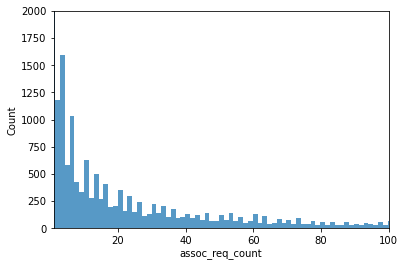

In [29]:

fig, ax = plt.subplots()
sns.histplot(data = macs, x = 'assoc_req_count', ax = ax)
 
# change the limits of X-axis
ax.set_xlim(1, 100)
ax.set_ylim(0, 2000)
plt.show()

Leftward skewed

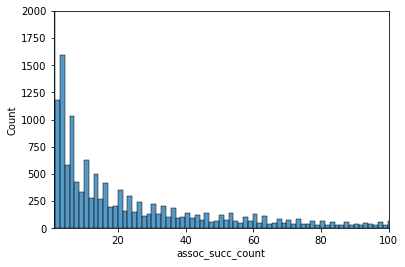

In [30]:
sns.histplot(data = macs, x = 'assoc_succ_count', ax = ax)
plt.show()

In [35]:
sns.histplot(data = macs, x = 'auths_count', ax = ax)
plt.show()

ValueError: autodetected range of [-inf, 4.38142195796735] is not finite